# Setup

**Imports**

In [71]:
!pip install ruptures
!pip install loadmydata
!pip install pygsp
!pip install geopandas
!pip install contextily
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
import datetime as dt
from math import log
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.signal import chirp, stft, sweep_poly, spectrogram
import tqdm
from kneed import KneeLocator
import scipy
rng = np.random.default_rng()
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.spatial.distance import pdist, squareform
from math import asin, cos, radians, sin, sqrt
import seaborn as sns
from pygsp import graphs
import pandas as pd
from matplotlib.dates import DateFormatter
from scipy.linalg import eigh
import geopandas
import contextily as cx


In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
path_to_assignment3 = "/content/drive/MyDrive/Cours_MVA/2nd semestre/Times series and ML/Assignment3/"

**Utility functions**

In [75]:
tones = {"1": (697, 1209), "2": (697, 1336), "3": (697, 1477), "4": (770, 1209), "5": (770, 1336), "6": (770, 1477), "7": (852, 1209), "8": (852, 1336), "9": (852, 1477), "0": (941, 1336), "*": (941, 1209), "#": (941, 1477), "A": (697, 1633), "B": (770, 1633), "C": (852, 1633), "D": (941, 1633)}
FS = 22_050  # Hz
sigma = 2

freqs_table = [697, 770, 852, 941, 1209, 1336, 1477, 1633]


In [76]:
def generate_symbol(symbol, duration, fs):
    """Generate the sound for number with given duration"""
    # get both frequencies for the symbol
    f1, f2 = tones[symbol]
    # time array
    time_arr = np.arange(0, duration, 1 / fs)
    # audio signal
    signal = np.cos(2 * np.pi * f1 * time_arr) + np.cos(2 * np.pi * f2 * time_arr)
    return signal

def generate_signal():
    n_symbols = rng.integers(3, 12)
    list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)

    list_of_segments = list()

    for symbol in list_of_symbols:
        duration = rng.uniform(low=0.05, high=0.2)  # seconds
        # generate tone
        symbol_signal = generate_symbol(symbol=symbol, duration=duration, fs=FS)
        # generate silence
        silence = np.zeros(int(duration*FS))
        # append tone and silence
        list_of_segments.extend([symbol_signal, silence])

    # silence at the start
    silence = np.zeros(int(duration*FS))
    list_of_segments = [silence] + list_of_segments

    signal = np.concatenate(list_of_segments)
    n_samples = signal.shape[0]
    time_array = np.arange(n_samples) / FS
    
    # add nuissance
    inst_freq = np.sin(2 * np.pi * 1.2 * time_array) * 1500 + 2000
    poly = np.polyfit(x=time_array, y=inst_freq, deg=14)
    sin_freq = sweep_poly(time_array, poly)
    signal += sin_freq
    # add white noise
    signal += rng.normal(scale=sigma, size=n_samples)

    return signal, list_of_symbols.tolist()

# Question 1 & 2 


[Dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) is a procedure to encode symbols using audio signal.

A symbold is represented by a sum of cosine waves: for $t=0,1,\dots,T-1$,

$$
y_t = \cos(2\pi f_1 t/f_s) + \cos(2\pi f_2 t/f_s)
$$
where each combination of $(f_1, f_2)$ represents a symbols (see table below).


|         | 1209 Hz  | 1336 Hz  | 1477 Hz  | 1633 Hz  |
|---------|----------|----------|----------|----------|
| **697 Hz**  | 1        | 2        | 3        | A        |
| **770 Hz**  | 4        | 5        | 6        | B        |
| **852 Hz**  | 7        | 8        | 9        | C        |
| **941 Hz**  | *        | 0        | #        | D        |

In [90]:
signal, symbols = generate_signal()
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

# 2 1 D 8 4 D # 3 3 5


In [95]:
def get_bkps(signal_tf, max_bkps):
    all_errors = []
    all_bkps = []
    algo = rpt.Dynp().fit(signal_tf)
    for n_bkp in range(1, max_bkps + 1):
        bkps = algo.predict(n_bkps=n_bkp)
        error = algo.cost.sum_of_costs(bkps)
        all_errors.append(error)
        all_bkps.append(bkps)
    kn = KneeLocator(range(max_bkps), np.array(all_errors).squeeze(),
                     curve='convex', direction='decreasing')
    bkps = all_bkps[kn.knee]
    return bkps, all_errors, kn.knee

def get_sound_freq(signal_tf, bkps):
    mean_freq_per_bkp = []
    idx_0 = []
    idx_1 = []
    for i in range(len(bkps)):
        if i == 0:
            tmp = signal_tf[:bkps[i]].mean(axis=0)
        else:
            tmp = signal_tf[bkps[i - 1]:bkps[i]].mean(axis=0)
        mean_freq_per_bkp.append(tmp)
    max_freq_noise = np.array(mean_freq_per_bkp)[:, 21:].max()
    for tmp in mean_freq_per_bkp:
        tmp_idx_0 = np.argmax(tmp)
        if tmp[tmp_idx_0] < max_freq_noise:
            idx_0.append(0)
            idx_1.append(0)
            continue
        tmp[tmp == np.max(tmp)] = 0
        tmp_idx_1 = np.argmax(tmp)
        if tmp_idx_0 > tmp_idx_1:
            tmp_idx_0, tmp_idx_1 = tmp_idx_1, tmp_idx_0
        idx_0.append(tmp_idx_0)
        idx_1.append(tmp_idx_1)
    return idx_0, idx_1, mean_freq_per_bkp

def find_closest_freq(freq, list_of_freq):
    return list_of_freq[np.argmin(np.abs(np.array(list_of_freq) - freq))], \
           np.min(np.abs(np.array(list_of_freq) - freq))

def decode_idx(idx_0, idx_1, list_of_freq_0, list_of_freq_1, verbose=False):
    res = []
    for i in range(len(idx_0)):
        f1, f1_err = find_closest_freq(f[idx_0[i]], list_of_freq_0)
        f2, f2_err = find_closest_freq(f[idx_1[i]], list_of_freq_1)
        if f1_err > 50 or f2_err > 50:
            if verbose:
                print(f"SILENCE ->  {max(f1_err, f2_err)}")
        else:
            if verbose:
                print(f"bkp {i}: {f1} {f2}")
            key = next(key for key, value in tones.items() if value == (f1, f2))
            res.append(key)
    return res

The original signal is # 2 1 D 8 4 D # 3 3 5
The decoded signal is  # 2 1 D 8 4 # 3 3


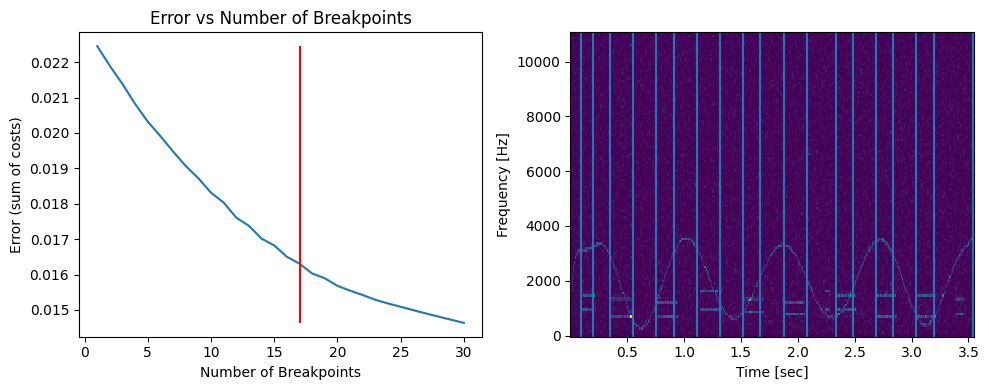

In [108]:
f, t, Sxx = spectrogram(signal, FS)
signal_tf = np.abs(Sxx).T
max_bkps = 30
    
bkps, all_errors, n_bkps = get_bkps(signal_tf, max_bkps)
idx_0, idx_1, mean_freq_per_bkp = get_sound_freq(signal_tf, bkps)
first_dim = [697, 770, 852, 941]
second_dim = [1209, 1336, 1477, 1633]
res = decode_idx(idx_0, idx_1, first_dim, second_dim, verbose=False)
print(f'The original signal is {" ".join(symbols)}')
print(f'The decoded signal is  {" ".join(res)}')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(1,max_bkps+1), all_errors)
ax[0].vlines(n_bkps, min(all_errors), max(all_errors), color="red")
ax[0].set_title("Error vs Number of Breakpoints")
ax[0].set_xlabel("Number of Breakpoints")
ax[0].set_ylabel("Error (sum of costs)")

ax[1].pcolormesh(t, f, Sxx)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
for b in bkps:
    ax[1].axvline(t[b-1])

fig.tight_layout()

Sound 1

In [103]:
sound_1 = np.loadtxt(path_to_assignment3 + "signal_1.csv")
IPython.display.Audio(sound_1, rate=FS)

The decoded signal is  B 9 4 B 3 1


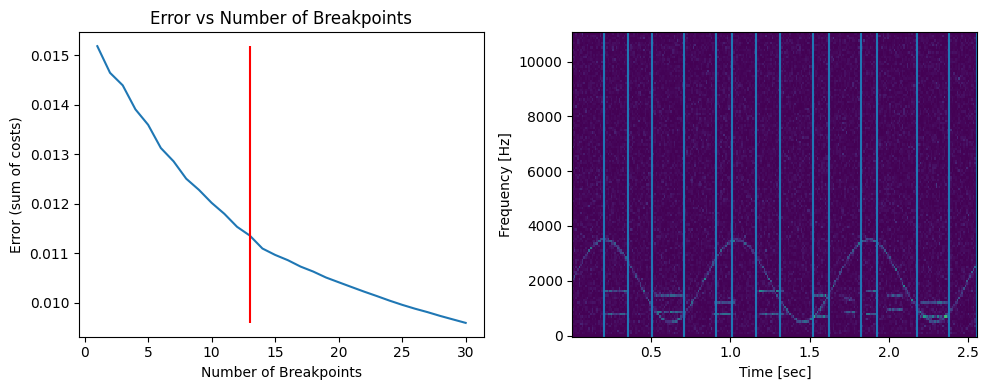

In [105]:
f, t, Sxx = spectrogram(sound_1, FS)
signal_tf = np.abs(Sxx).T
max_bkps = 30

bkps, all_errors, n_bkps = get_bkps(signal_tf, max_bkps)
idx_0, idx_1, mean_freq_per_bkp = get_sound_freq(signal_tf, bkps)
first_dim = [697, 770, 852, 941]
second_dim = [1209, 1336, 1477, 1633]
res = decode_idx(idx_0, idx_1, first_dim, second_dim, verbose=False)
print(f'The decoded signal is  {" ".join(res)}')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(1,max_bkps+1), all_errors)
ax[0].vlines(n_bkps, min(all_errors), max(all_errors), color="red")
ax[0].set_title("Error vs Number of Breakpoints")
ax[0].set_xlabel("Number of Breakpoints")
ax[0].set_ylabel("Error (sum of costs)")

ax[1].pcolormesh(t, f, Sxx)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
for b in bkps:
    ax[1].axvline(t[b-1])

fig.tight_layout()

Sound 2

In [106]:
sound_2 = np.loadtxt(path_to_assignment3 + "signal_2.csv")
IPython.display.Audio(sound_1, rate=FS)

The decoded signal is  C D 1 1 6 3


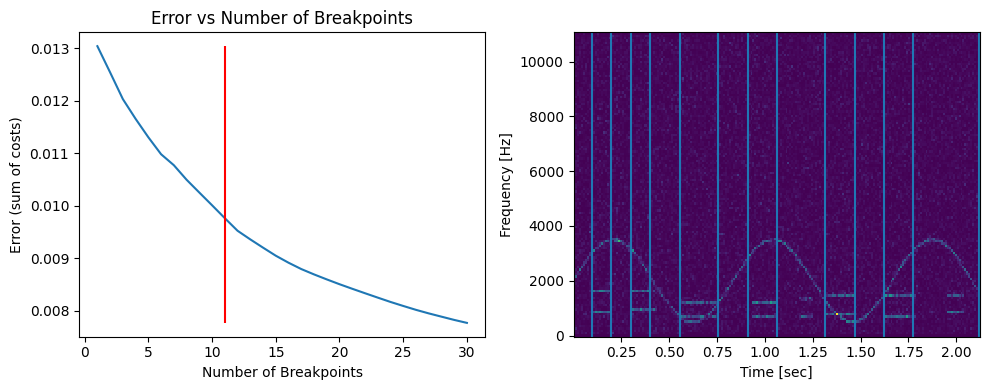

In [107]:
f, t, Sxx = spectrogram(sound_2, FS)
signal_tf = np.abs(Sxx).T
max_bkps = 30

bkps, all_errors, n_bkps = get_bkps(signal_tf, max_bkps)
idx_0, idx_1, mean_freq_per_bkp = get_sound_freq(signal_tf, bkps)
first_dim = [697, 770, 852, 941]
second_dim = [1209, 1336, 1477, 1633]
res = decode_idx(idx_0, idx_1, first_dim, second_dim, verbose=False)
print(f'The decoded signal is  {" ".join(res)}')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(1,max_bkps+1), all_errors)
ax[0].vlines(n_bkps, min(all_errors), max(all_errors), color="red")
ax[0].set_title("Error vs Number of Breakpoints")
ax[0].set_xlabel("Number of Breakpoints")
ax[0].set_ylabel("Error (sum of costs)")

ax[1].pcolormesh(t, f, Sxx)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
for b in bkps:
    ax[1].axvline(t[b-1])

fig.tight_layout()

# Question 3

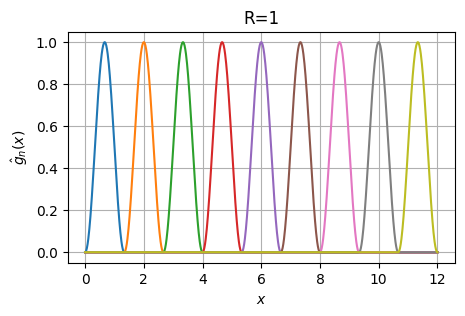

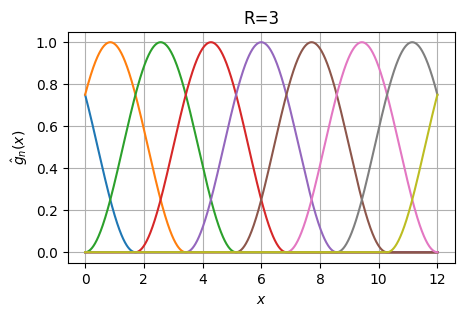

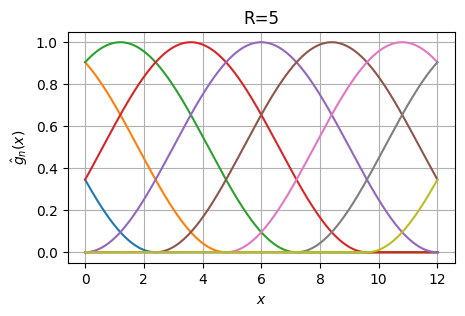

In [110]:
def calculate_g(x_max, R_value, n_points=1000):
    N = 9
    a_value = x_max / (N + 1 - R_value)
    g_array = np.zeros((N, n_points))
    x_array = np.linspace(0, x_max, n_points)
    for m in range(1, N + 1):
        current_x = x_array - a_value * m
        temp = 1+np.cos(2*np.pi*(current_x/(a_value*R_value)+0.5))
        g_array[m - 1, :] = np.where(
            np.logical_and(current_x < 0, current_x >= -a_value * R_value),
            temp,
            0
        )
    return 0.5 * g_array

x_max = 12
n_points = 1000
for i, R_value in enumerate([1, 3, 5]):
    fig, ax = plt.subplots(figsize=(5, 3))
    g_values = calculate_g(x_max, R_value, n_points=n_points)
    for n in range(g_values.shape[0]):
        ax.plot(
            np.linspace(0, x_max, n_points),
            g_values[n],
            color=f'C{n}',
            label=f"n={n+1}"
        )
    ax.set_title(f"R={R_value}")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\hat{g}_n(x)$")
    ax.grid()
    plt.savefig(f"fig_{i}_output.png")
    plt.show()


# Question 4

In [146]:
data_df, stations_df, description = load_molene_meteo_dataset()

In [147]:
# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius
temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)

# drop stations with missing values
print(temperature_df.columns[temperature_df.isna().any()].tolist())
temperature_df.dropna(axis=1, inplace=True)
stations_df = stations_df[stations_df['Nom'].isin(temperature_df.columns)]

['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


In [148]:
data_df.head()

,numer_sta,date,date_insert,td,t,tx,tn,u,ux,un,...,vv,etat_sol,sss,n,insolh,ray_glo01,pres,pmer,station_name,temp
0,29293001,2014-01-01 00:00:00,2014-01-01 00:05:55,280.25,283.95,283.95,283.65,78.0,80.0,73.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,10.8
1,29293001,2014-01-01 01:00:00,2014-01-01 01:05:59,280.35,284.05,284.05,283.95,78.0,79.0,74.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,10.9
2,29293001,2014-01-01 02:00:00,2014-01-01 02:16:05,280.45,283.75,284.05,283.65,80.0,80.0,76.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,10.6
3,29293001,2014-01-01 03:00:00,2014-01-01 03:06:09,279.85,283.95,283.95,283.25,76.0,82.0,75.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,10.8
4,29293001,2014-01-01 04:00:00,2014-01-01 04:06:14,281.15,284.15,284.15,283.95,82.0,82.0,72.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,TREGUNC,11.0


In [149]:
def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [150]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr


In [166]:
# Compute the graph using distance matrix and exponential smoothing
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.861 #minimum threshold is 0.861
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
G_gaussian
print(
    f"The graph is {'not ' if not G_gaussian.is_connected(recompute=True) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges"
)
print("The mean degree is", round(G_gaussian.d.mean(), 3))

The graph is not connected, with 37 nodes, 56 edges
The mean degree is 3.027


In [170]:
laplacian_matrix = G_gaussian.L.todense()


signals = temperature_df.to_numpy()
smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df.index
)

least_smooth_idx = np.argmax(smoothness_arr)
smoothest_idx = np.argmin(smoothness_arr)
print('The least smooth signal is from', temperature_df.index[least_smooth_idx])
print('The smoothest signal is from', temperature_df.index[smoothest_idx])


The least smooth signal is from 2014-01-10 09:00:00
The smoothest signal is from 2014-01-24 19:00:00


# Question 5

In [171]:
least_smooth_signal = signals[least_smooth_idx]
smoothest_signal = signals[smoothest_idx]
first_signal = temperature_df.iloc[0].to_numpy()

R = 3

laplacian_matrix = G_gaussian.L.todense()
lambda_l, u_l = eigh(laplacian_matrix)

In [134]:
def compute_g(lambda_n, R, n_points=1000):
    M = 9
    a = lambda_n/(M+1-R)
    g = np.zeros((M, n_points))
    lbd = np.linspace(0, lambda_n, n_points)
    for m in range(1, M+1):
        curr_lbd = lbd-a*m
        tmp = 1+np.cos(2*np.pi*(curr_lbd/(a*R)+0.5))
        g[m-1, :] = np.where(np.logical_and(curr_lbd<0, curr_lbd>=-a*R), tmp, 0)
    return 0.5*g

def compute_W(lambda_l, f, u_l, R, idx_node):
    M = 9
    W_f = []
    a = lambda_l.max()/(M+1-R)    
    for m in range(1, M+1):
        g = np.zeros(len(lambda_l))
        curr_lbd = lambda_l-a*(m)
        tmp = 1+np.cos(2*np.pi*(curr_lbd/(a*R)+0.5))
        g = np.where(np.logical_and(curr_lbd<0, curr_lbd>=-a*R), tmp, 0)
        f_four = u_l.T.dot(f)
        W = 0.5*g*f_four*u_l[:, idx_node]
        W_f.append(W.sum().copy())
    return W_f

def compute_class(signal, lambda_l, u_l, R):
    W_f = []
    for node in range(signal.shape[0]):
        W_f.append(compute_W(lambda_l, signal, u_l, R, node))

    W_f = np.array(W_f)
    W_f_square  = np.square(W_f)
    energy_0_3 = W_f_square[:, 0:3].sum(axis=1)
    energy_3_6 = W_f_square[:, 3:6].sum(axis=1)
    energy_6_9 = W_f_square[:, 6:9].sum(axis=1)
    node_class = np.argmax(np.stack([energy_0_3, energy_3_6, energy_6_9]), axis=0)
    return node_class

In [172]:
def compute_g(lambda_n, R, n_samples=1000):
    num_bands = 9
    band_width = lambda_n / (num_bands + 1 - R)
    g = np.zeros((num_bands, n_samples))
    lambda_samples = np.linspace(0, lambda_n, n_samples)
    for m in range(1, num_bands + 1):
        curr_lambda = lambda_samples - band_width * m
        cos_term = np.cos(2 * np.pi * (curr_lambda / (band_width * R) + 0.5))
        g[m - 1, :] = np.where(np.logical_and(curr_lambda < 0, curr_lambda >= -band_width * R), 1 + cos_term, 0)
    return 0.5 * g


def compute_W(lambda_l, signal, u_l, R, node_idx):
    num_bands = 9
    W = []
    max_band_width = lambda_l.max() / (num_bands + 1 - R)    
    for m in range(1, num_bands + 1):
        g = np.zeros(len(lambda_l))
        curr_lambda = lambda_l - max_band_width * m
        cos_term = np.cos(2 * np.pi * (curr_lambda / (max_band_width * R) + 0.5))
        g = np.where(np.logical_and(curr_lambda < 0, curr_lambda >= -max_band_width * R), 1 + cos_term, 0)
        f_fourier = u_l.T.dot(signal)
        W_m = 0.5 * g * f_fourier * u_l[:, node_idx]
        W.append(W_m.sum().copy())
    return W


def compute_class(signal, lambda_l, u_l, R):
    W = []
    for node_idx in range(signal.shape[0]):
        W.append(compute_W(lambda_l, signal, u_l, R, node_idx))
    
    W = np.array(W)
    W_sq = np.square(W)
    energy_0_3 = W_sq[:, 0:3].sum(axis=1)
    energy_3_6 = W_sq[:, 3:6].sum(axis=1)
    energy_6_9 = W_sq[:, 6:9].sum(axis=1)
    node_class = np.argmax(np.stack([energy_0_3, energy_3_6, energy_6_9]), axis=0)
    return node_class


In [173]:
names = ['least_smooth_signal', 'smoothest_signal', 'first_signal']
signals = [least_smooth_signal, smoothest_signal, first_signal]

In [175]:
for i, signal in enumerate(signals):
    node_class = compute_class(signal, lambda_l, u_l, R)
    stations_gdf = geopandas.GeoDataFrame(
        stations_df,
        geometry=geopandas.points_from_xy(
            stations_df.Longitude, stations_df.Latitude
        ),
    ).set_crs(CRS)

    colors = ["b", "m", "r"]
    cols = [colors[i] for i in node_class]
    ax = stations_gdf.geometry.plot(figsize=(10, 5), c=cols)
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    plt.plot()
    plt.savefig(f"{names[i]}_real.png", dpi=300, bbox_inches="tight")
    plt.close()

# Question 6

In [176]:
q_6_col_array = []
q_6_y = []
q_6_x = []
for i in range(len(temperature_df)):
    curr_signal = temperature_df.iloc[i].to_numpy()
    node_class = compute_class(curr_signal, lambda_l, u_l, R)
    mean_temp = curr_signal.mean()
    maj_class = np.argmax(np.bincount(node_class))
    q_6_col_array.append(maj_class)
    q_6_y.append(mean_temp)
    q_6_x.append(temperature_df.index[i])

In [177]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

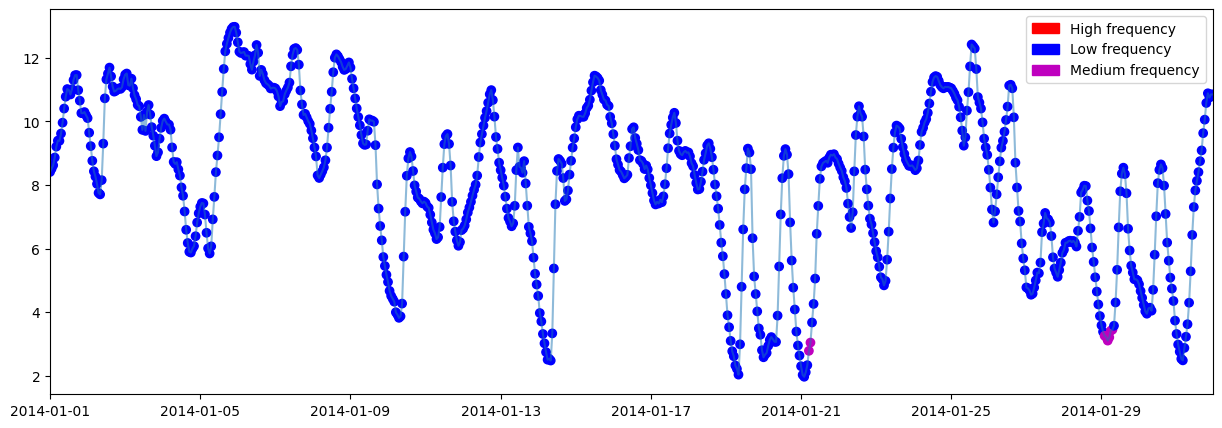

In [178]:
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
y = q_6_y
x = q_6_x  
class_array = np.array(q_6_col_array)

colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
red_patch = mpatches.Patch(color='red', label='High frequency')
blue_patch = mpatches.Patch(color='blue', label='Low frequency')
magenta_patch = mpatches.Patch(color='m', label='Medium frequency')
ax.scatter(x, y, c=color_array);
ax.legend(handles=[red_patch, blue_patch, magenta_patch])
plt.savefig("q_6.png", dpi=300, bbox_inches="tight")

# Question 7